![header.png](https://lh4.googleusercontent.com/FWBHWkTBQHZQrtGwvdPeHwpTNJ2PQiQYa7zfSxQwhHH92n34SU9dkcbvp0BbBmtK1djie1C1_f8Y9t8XbDHYXxlO5PKQZO2JdB_Xfe_4wD9GIEcUW6KSoE8YzVioVVOPQQ=w5014)

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

# Challenge 09: Building Neural Networks from Scratch

> > Relying upon a finger, we see the moon
> >
> > Relying upon the moon, we understand the finger.
> >
> > Moon and finger
> >
> > Are neither the same nor different.
> >
> > This expedient analogy is for guiding beginners.
> >
> > Having seen reality as it is,
> >
> > There is neither moon nor finger.
>
> — Ryōkan (19th century Buddhist monk), in _Ryokan Interpreted_ (2021)

In a previous challenge, you learned the art of training neural networks in broad strokes. Here, you will learn the _craft_.

What I mean by that is: the understand what a neural network is, the first step is to build it from first principles. It's very difficult to get an understanding of a thing without knowing every single part that makes it up. Every part, down to the individual units too simple to doubt.

Central to this process is the notion of a _computation graph_, which is a fancy way of saying _"let's keep track of all the operations in this mathematical expression"_. We will build such a graph starting with scalars, i.e. numbers, or one of the simplest possible things you probably already know like the back of your hand, and it will turn out that all the fancy stuff people say about neural networks is just stuff that happens to this graph.

Here is an example. Let $ f(x, y, z) = (x + y) z$. Then its computation graph is simply:

![](https://i.imgur.com/qtIxzZc.png)

Not so bad, is it? Pause for a bit and consider this more.

Do you see what we're trying to gesture at here? Much of serious learning is about finding the right _form_. It is often said that in the martial arts, all practice without good form is wasted. Here, the claim is that this computation graph is the first fundamental _correct_ form of neural network science: without it, reading papers and watching YouTube videos about them will not lead to clarity. If there's anything you will take away from doing these challenges, let it be this.

This is not to say though that this model is enough to fully characterise all the behaviour of neural networks—that is why our field remains an active science—but without this exact, mechanical understanding under your belt, it would be like doing chemistry without atoms.

And so, by the end of this challenge, you should be able to:

- [ ] Fully understand what it means when someone talks about a _neural network_
- [ ] Build such a network yourself using good ol' `pytorch` tensors

_Note: most of this is strip-mined from Andrej Karpathy's _[Neural Networks: Zero to Hero](https://www.youtube.com/watch?v=VMj-3S1tku0)_ lecture on `micrograd`. In a very real sense, this challenge is really an excuse to have you watch it because it is a shining example of what is possible when you really care about teaching something. Do not hesitate to refer to it if anything here isn't making sense._

---

## Part I: Change

> [!IMPORTANT]
> To run this notebook, you'll need the `graphviz` package. See [this page](https://www.graphviz.org/download/) for installation instructions.

In [2]:
# Note: graphviz the pip package is not the same as graphviz the tool
%pip install graphviz torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [3]:
import numpy as np
import plotly.express as px
import graphviz

import torch
import torchviz
import re

---

Consider the function $f(x) = x^2$. How do we know how much it changes when its input $x$ changes?

Forget what you know about calculus for the moment. Given you and your Jupyter notebook, how can you figure this out?

Well, one way would be to just make a plot and call it a day:

In [4]:
xs = np.arange(-2, 2, 0.1)
ys = [x**2 for x in xs]

fig = px.line(x=xs, y=ys, template='ggplot2')
fig.show()

This is quick and easy, I guess, and it's a really good habit to have to visualise things first before diving into the details. But is there a different way? Something that we can play with?

One thing we can try is to literally change $x$ by a small amount (say $h = 0.01$) and see what happens.

In [5]:
# This one-liner is equivalent to:
# def f(x):
#     return x**2
f = lambda x: x**2

x = 2
h = 0.01

print(f'x: {x}')
print(f'f(x): {f(x)}')
print(f'f(x+h): {f(x+h)}')
print(f'f(x+h) - f(x): {f(x+h) - f(x)}')

x: 2
f(x): 4
f(x+h): 4.040099999999999
f(x+h) - f(x): 0.040099999999998914


And so we see that, for every change $h = 0.01$ in $x$, we change $f(x)$ by $\approx 0.04$. And we can test different combinations of $x$ and $h$ to get a feel for how sensitive $f(x)$ is to changes in $x$. But really, what we want is a principled way of doing this for _any_ function we will come across [1]. And that of course, comes to us in the form of the **derivative**:

$$
\frac{df}{dx} \equiv \lim_{h \to 0}{\frac{f(x+h) - f(x)}{h}}
$$

Since computers have finite memory, we can only really approximate this limit by setting $h$ to smaller and smaller values. But it turns out, that this is enough for most cases, and it is very rare to encounter scenarios where this approximation will fail unless you're looking for them.


[1]: The birth of modern mathematics can be said to have started by trying to figure out precisely which functions we can't do this for, sc. Karl Weierstrass' early work on the definition of continuity.

### Problem 1: Write a function `derivative` that takes a (mathematical) function $f$ and an input $x_0$ and gives you the approximate derivative of $f$ at $x_0$.

In [6]:
# h := step_size
def derivative(x, f = None, step_size=1e-5):
    out = 0
    # YOUR CODE HERE
    h = step_size
    out = (1/h) * (f(x + h) - f(x))
    return out

In [7]:
x = 2.0
assert derivative(2.0, f = lambda x: x**2, step_size=1e-5) - 2*x < 0.1

---

With this out of the way, let's start by defining the base class from which we'll build out everything we need. In particular, we'll be defining a class `T` that will behave almost exactly like `torch.Tensor` but has additional attributes that will be useful to us when building out the computation graph later.

_Note: if you need a refresher on how to use classes in Python, you can [read this guide](https://book.pythontips.com/en/latest/classes.html)._

In [8]:
class T:
    def __init__(self, tensor):
        # Casts the argument to a torch.Tensor if it isn't already one
        if not isinstance(tensor, torch.Tensor):
            tensor = torch.tensor(tensor, dtype=torch.float64)

        self.tensor = tensor

    # What happens when you print T
    def __repr__(self):
        return f'T(item={self.tensor.item()})'

    # E.g. when we do T.size, we're really doing T.tensor.size
    def __getattr__(self, name):
        return getattr(self.tensor, name)

In [9]:
x = T([1.0])

print(f'x: {x}')
print(f'x.item(): {x.item()}')
print(f'x.dtype: {x.dtype}')
print(f'x.size: {x.size()}')

x: T(item=1.0)
x.item(): 1.0
x.dtype: torch.float64
x.size: torch.Size([1])


**Q**: Is `T(1.0)` equal to `T([1.0])`?

<details>
<summary>Answer</summary>

No, just as `torch.Tensor(1)` and `torch.Tensor([1])` are not.
</details>

In [10]:
torch.equal(T(1.0).tensor, T([1.0]).tensor)

False

On its own, it's not interesting yet. So let's make it so that we can add two `T`s with the addition operator `+`. We do this by _overloading_ the `__add__` method of `T`:

> [!NOTE]
> You can find a list of such magic methods in Python's [official documentation](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types). Our primary task in this section is to override the right magic methods so that we can build expressions using the class `T`.

In [11]:
def add(self, other):
    # Casts other to T if it's not one yet,
    if not isinstance(other, T):
        other = T(other)
    return T(self.tensor + other.tensor)

T.__add__ = add

a = T([1.0])
b = T([2.0])
c = a + b

print(f'c: {c}')
print(f'c + 2.0: {c + 2.0}')
print(f'Is __add__ in dir(T)?: {"__add__" in dir(T)}')

c: T(item=3.0)
c + 2.0: T(item=5.0)
Is __add__ in dir(T)?: True


So far, so good. What about the multiplication operator `*`?

In [12]:
def mul(self, other):
    if not isinstance(other, T):
        other = T(other)
    return T(self.tensor * other.tensor)

T.__mul__ = mul

a = T([2.0])
b = T([3.0])
c = a * b

print(f'c: {c}')
print(f'Is __mul__ in dir(T)?: {"__mul__" in dir(T)}')

c: T(item=6.0)
Is __mul__ in dir(T)?: True


While we're at it, let's define two more useful overloads in terms of the ones we just wrote:

In [13]:
# Negation; this uses __mul__ above
def neg(self):
    return self * -1

# Subtraction; this uses __add__ above
def sub(self, other):
    return self + (-other)

T.__neg__ = neg
T.__sub__ = sub

a = T([2.0])
b = T([3.0])
c = T([4.0])

d = a + b - c * a
print(f'd: {d}')

d: T(item=-3.0)


Okay, we've recovered some `torch.Tensor` functionality, but what we want is to keep track of useful things so we can build out more complicated expressions later on. To do that, we'll modify the `__init__` method of the class `T` (we'll be doing this a lot in this notebook) and add a couple of attributes:

* `T.label` which is basically a name
* `T._op` which will tell us if the `T` was created via some operation
* `T._prev` which will keep track of which `T`s this `T` comes from, via `T._op`

> [!NOTE]
> In case you've forgotten, the `__init__` method of a class is called when you create an instance of that class, e.g. by writing `obj = T([2.0])`

In [14]:
def init(self, tensor, _children=(), _op='', label=''):
    if not isinstance(tensor, torch.Tensor):
        tensor = torch.tensor(tensor, dtype=torch.float64)

    self.tensor = tensor
    self.label = label
    self._op = _op
    self._prev = set(_children)

T.__init__ = init

Now, we have to modify `__add__` and `__mul__` so that they can fill in these new attributes:

In [15]:
def add(self, other):
    if not isinstance(other, T):
        other = T(other)
    return T(self.tensor + other.tensor, (self, other), '+')

def mul(self, other):
    if not isinstance(other, T):
        other = T(other)
    return T(self.tensor * other.tensor, (self, other), '*')

T.__add__ = add
T.__mul__ = mul

a = T([1.0])
b = T([2.0])
c = a * b

print(f'c._op: {c._op}')
print(f'c._prev: {c._prev}')

c._op: *
c._prev: {T(item=2.0), T(item=1.0)}


**Q**: So far, is `a * 2` equal to `2 * a`?

<details>
<summary>Answer</summary>

No, at least not yet. The reason for this is that `__add__` and `__mul__` are not commutative by default. We need to define `__radd__` and `__rmul__` so that they will work as expected.
</details>

In [16]:
def radd(self, other):
    return self + other

def rmul(self, other):
    return self * other

T.__radd__ = radd
T.__rmul__ = rmul

Let us now visualise these expressions. Here are some helper functions we need:

* `trace` recursively builds a (directed) graph of which expressions depend on which, based on each `T._prev`
* `draw_dot` renders this graph using a library called `graphviz`, where:
  * inputs are coloured light blue
  * operators and intermediate values are coloured grey
  * outputs are coloured olive green

In [17]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)

    build(root)

    return nodes, edges

def draw_dot(root):
    node_attr = dict(style='filled',
                 shape='box',
                 align='left',
                 fontsize='10',
                 ranksep='0.1',
                 height='0.2',
                 fontname='monospace')

    dot = graphviz.Digraph(format='png', node_attr=node_attr)

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        fill_color = 'lightblue' if not n._op else '' if not uid == str(id(root)) else 'darkolivegreen3'

        if n.grad is not None:
            dot.node(name = uid, label = "{ %s | item %.4f | grad %.4f}" % (n.label, n.item(), n.grad), shape='record', fillcolor=fill_color)
        else:
            dot.node(name = uid, label = "{ %s | item %.4f }" % (n.label, n.item()), shape='record', fillcolor=fill_color)

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

Great! Now we can draw our first **computation graph**:

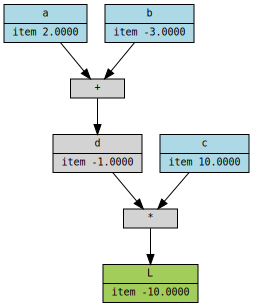

In [18]:
a = T([2.0], label='a')
b = T([-3.0], label='b')
c = T([10.0], label='c')

d = a + b   ; d.label = 'd'
L = d * c   ; L.label = 'L'

draw_dot(L)

Essentially, what this tells us is that, by starting from the inputs (light blue), we can follow the arrows (aka **forward-pass**) to get the output (olive green).

Now, this graph isn't really useful yet as it is because right now, it's merely a different, but ultimately equivalent representation of mathematical expressions (in this case, `L`). What we really want is to calculate how the output changes when you vary each node by a small amount. And for that, we need to keep track of a quantity known as the **gradient**, which measures exactly how that variation will happen.

Here's what we'll do:

1. First, modify `T.__init__` to have a new attribute `T.grad` which just holds floats.
2. For each node $x_i$ in the graph, calculate the derivative $dL/dx_i$ of $L$ with respect to it and put the result in its corresponding `T.grad`
3. Update each node's value accordingly.

### Problem 2: Add the attribute `T.grad` to `T` and initialise it to `0.0`

In [20]:
def init(self, tensor, _children=(), _op='', label=''):
    # YOUR CODE HERE
    # take from previous
    if not isinstance(tensor, torch.Tensor):
        tensor = torch.tensor(tensor, dtype=torch.float64)

    self.tensor = tensor
    self.label = label
    self._op = _op
    self._prev = set(_children)
    self.grad = 0.0

T.__init__ = init

In [21]:
assert hasattr(T([0.0]), "grad")
assert T([0.0]).grad == 0.0

Let's redraw our graph (and put it in a 'staging area' so we don't pollute the global namespace):

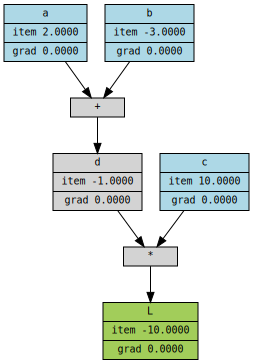

In [22]:
def stage_1():
    a = T([2.0], label='a')
    b = T([-3.0], label='b')
    c = T([10.0], label='c')

    d = a + b   ; d.label = 'd'
    L = d * c   ; L.label = 'L'

    return draw_dot(L)

stage_1()

> [!NOTE]
> Since these graphs are generated on the fly, the position of each node might get moved around (which really doesn't change the _meaning_ of the figure, mind you). Make sure to pay attention to the labels!

Our next task then is to calculate those gradients.

First, let's start with `L`.

**Q**: What is $dL/dL$?

<details>
<summary>Answer</summary>

1; or in other words, changing `L` by some amount will change `L` by, well, exactly the same amount.
</details>

Right, so we can actually verify this, right? We can calculate $dL/dL$:

In [24]:
h = 1e-5

# Note: we want the value L.item(), not L itself
dL_dL = ((L.item() + h) - L.item()) / h
dL_dL

L.grad = dL_dL
L.grad

0.9999999999621422

Okay, now what is $dL/dc$? We can vary `c` then see how `L` responds:

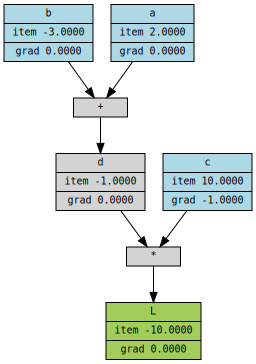

In [26]:
def stage_2():
    # stepsize
    h = 1e-3

    # like f(x)
    # original values
    a = T([2.0], label='a')
    b = T([-3.0], label='b')
    c = T([10.0], label='c')
    # save original value
    c_orig = c.tensor

    # original operations and results
    d = a + b   ; d.label = 'd'
    L = d * c   ; L.label = 'L'
    L1 = L.item()

    # like f(x+h)
    # modified values
    a = T([2.0], label='a')
    b = T([-3.0], label='b')
    c = T([10.0 + h], label='c') # c + h

    # modified operations and results
    d = a + b   ; d.label = 'd'
    L = d * c   ; L.label = 'L'
    L2 = L.item()

    # find and set the derivative
    dL_dc = (L2 - L1) / h
    c.grad = dL_dc

    c.tensor = c_orig # revert to original
    L.tensor = torch.Tensor([L1]) # revert to original
    return draw_dot(L)

stage_2()

And this makes sense, right? Since $L = d * c$, we have $dL/dc = d$.

Now, what is $dL/dd$?

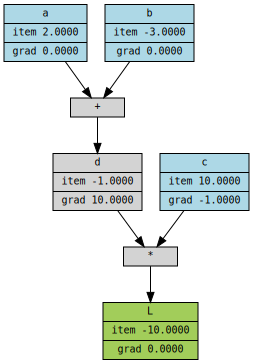

In [28]:
def stage_3():
    h = 1e-3

    # like f(x)
    a = T([2.0], label='a')
    b = T([-3.0], label='b')
    c = T([10.0], label='c')

    d = a + b   ; d.label = 'd'
    d_orig = d.tensor
    L = d * c   ; L.label = 'L'
    L1 = L.item()

    # like f(x + h)
    a = T([2.0], label='a')
    b = T([-3.0], label='b')
    c = T([10.0], label='c')

    d = a + b   ; d.label = 'd'
    d.tensor += h               # d + h
    L = d * c   ; L.label = 'L'
    L2 = L.item()

    dL_dd = (L2 - L1) / h
    d.grad = dL_dd

    d.tensor = d_orig # revert to original
    L.tensor = torch.Tensor([L1]) # revert to original

    c.grad = d.item() # from previous result
    return draw_dot(L)

stage_3()
# L = cd, dL/dd = c

What about $dL/da$? We know that $L = d + c \equiv d(a, b) + c$. That is, `d` is a function of a (and b), namely $d(a, b) = a + b$.

So, to calculate the derivative we actually need to invoke the chain rule:

$$
\frac{dL}{da} = \left( \frac{dL}{dd} \right) \left( \frac{dd}{da} \right)
$$

We already have $dL/dd$ from the previous calculation, but now we're interested in how `d` changes when `a` changes. Let us calculate then!

dL/dd : 10.0
dd/da: 0.9999999999998899


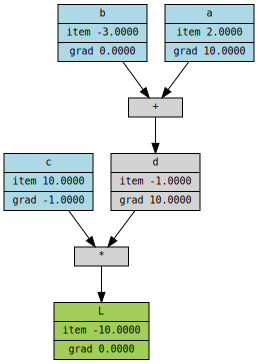

In [30]:
def stage_4():
    h = 1e-3

    # like f(x), save original values
    a = T([2.0], label='a') ; a_orig = a.tensor
    b = T([-3.0], label='b')
    c = T([10.0], label='c')

    d = a + b   ; d.label = 'd' ; d_orig = d.tensor
    L = d * c   ; L.label = 'L'
    L1 = L.item()
    d1 = d.item()

    # like f(x + h)
    a = T([2.0 + h], label='a') # a + h
    b = T([-3.0], label='b')
    c = T([10.0], label='c')

    d = a + b   ; d.label = 'd'
    L = d * c   ; L.label = 'L'
    d2 = d.item()

    # Chain 1: first, dL/dd
    d.grad = c.item() # from previous result (hardcoded)
    dL_dd = d.grad
    print(f'dL/dd : {dL_dd}')

    # Chain 2: second, dd/da
    dd_da = (d2 - d1) / h
    print(f'dd/da: {dd_da}')

    # dL/da = (dL/dd) * (dd/da)
    a.grad = dL_dd * dd_da

    d.tensor = d_orig # revert to original
    c.grad = d.item() # from previous result (hardcoded)

    a.tensor = a_orig # revert to original
    L.tensor = torch.Tensor([L1]) # revert to original
    return draw_dot(L)

stage_4()

### Problem 3: Calculate $dL/db$ and update `b.grad` accordingly.

Make sure to leave everything else unchanged.

dL/dd : 10.0
dd/db: 0.9999999999998899


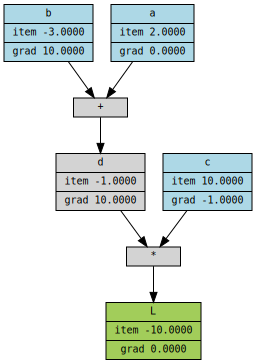

In [31]:
def stage_5():
    # YOUR CODE HERE
    h = 1e-3

    # like f(x), save original values only of variables of interest
    a = T([2.0], label='a')
    b = T([-3.0], label='b') ; b_orig = b.tensor
    c = T([10.0], label='c')

    d = a + b   ; d.label = 'd' ; d_orig = d.tensor
    L = d * c   ; L.label = 'L'
    # save original values
    L1 = L.item()
    d1 = d.item()

    # like f(x + h)
    a = T([2.0], label='a')
    b = T([-3.0 + h], label='b')
    c = T([10.0], label='c')

    d = a + b   ; d.label = 'd'
    L = d * c   ; L.label = 'L'
    d2 = d.item()
    # no need to compute L2 since we know dL/dd

    # Chain 1: first, dL/dd
    d.grad = c.item() # from previous result (hardcoded)
    dL_dd = d.grad
    print(f'dL/dd : {dL_dd}')

    # Chain 2: second, dd/db
    dd_db = (d2 - d1) / h
    print(f'dd/db: {dd_db}')

    # dL/db = (dL/dd) * (dd/db)
    b.grad = dL_dd * dd_db

    d.tensor = d_orig # revert to original
    c.grad = d.item() # from previous result (hardcoded)

    b.tensor = b_orig # revert to original
    L.tensor = torch.Tensor([L1]) # revert to original
    return draw_dot(L)
stage_5()

And there you have it: the complete **backpropagation** algorithm.

...really? Yes! Backpropagation, which we did here manually, is just calculating the gradient of some function (here, `L`) with respect to each value in the computation graph, starting from `L` and moving 'backwards' so you can take advantage of the chain rule to make the calculation more efficient.

What these gradients are telling us is that, if we nudge the value / item of each node by them, L should _increase_. And in fact from calculus this is in a very strict sense the 'most optimal' way to do so.

Updating the values (given by `T.item()`) based on said gradients what is known as an **optimisation step**. Let's see this in action:

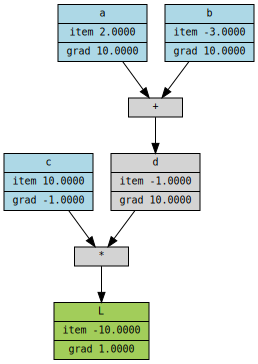

In [45]:
# First, set things up again

a = T([2.0], label='a')
b = T([-3.0], label='b')
c = T([10.0], label='c')

d = a + b   ; d.label = 'd'
L = d * c   ; L.label = 'L'

L.grad = 1.0
c.grad = -1.0
d.grad = 10.0
a.grad = 10.0
b.grad = 10.0

draw_dot(L)

Each node $x_i$ will then be nudged by $\Delta x_i = \nu \frac{dL}{dx_i}$, where $\nu$ is some factor called the **learning rate**.

> [!TIP]
> Curious what the learning rate $\nu$ is all about? Try setting $\nu = 10$, $= 1$, $= 0.1$, and $= 0.0001$ and check what happens to $L$!

In [46]:
nu = 0.01

print(f'L: {L.item()}')

a.tensor += nu * a.grad
b.tensor += nu * b.grad
c.tensor += nu * c.grad

d = a + b
L = d * c

print(f'L (new): {L.item()}')

L: -10.0
L (new): -7.991999999999998


### Problem 4: Perform a single optimisation step for `L` below and draw its computation graph

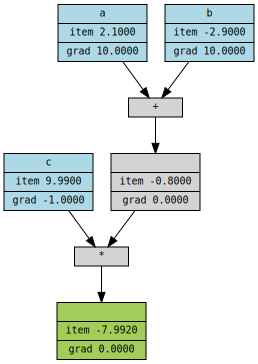

In [47]:
# YOUR CODE HERE
draw_dot(L)

L: -7.991999999999998
L (new): -5.9911964000000015


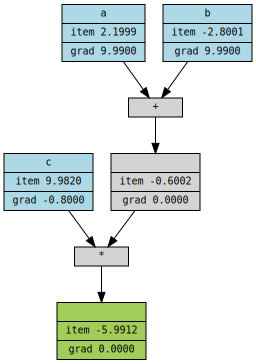

In [48]:
# further optimization steps
d = a + b   ; d.label = 'd'
L = d * c   ; L.label = 'L'

L.grad = 1.0
# dL/dc = d, dL/dd = c
c.grad = d.tensor
d.grad = c.tensor
# dd/da and dd/db = 1 ((a + b + h) - (a + b))/h
a.grad = d.grad * 1
b.grad = d.grad * 1

nu = 0.01

print(f'L: {L.item()}')

a.tensor += nu * a.grad
b.tensor += nu * b.grad
c.tensor += nu * c.grad

d = a + b
L = d * c

print(f'L (new): {L.item()}')
draw_dot(L)

### Part II: Neuron

One very useful function that we can add to our computation graph is the hyperbolic tangent $tanh(x)$, which looks like this:

In [37]:
xs = np.arange(-2, 2, 0.1)
ys = np.tanh(xs)

px.line(x=xs, y=ys, template='ggplot2')

What this does is to take whatever number you have in $(-\infty, \infty)$ and squash it to fit in $[-1, 1]$. Think about why this is useful for a second before moving on.

Now, the definition of $tanh(x)$ in terms of the exponential function $e^x$ is given by:

$$
\tanh{x} = \frac{e^{2x} - 1}{e^{2x} - 1}
$$

Hence:

In [49]:
def tanh(self):
    x = self.tensor
    t = (torch.exp(2*x) - 1) / (torch.exp(2*x) + 1)
    return T(t, (self,), 'tanh')

T.tanh = tanh

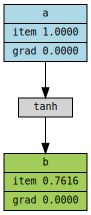

In [50]:
a = T([1.0]) ; a.label='a'
b = a.tanh() ; b.label='b'

draw_dot(b)

And the reason why this is useful is because we can use it as an **activation function** when building a neuron. But alas, we are getting ahead of ourselves.

What is a neuron? In its most basic form, this is what it looks like:

![](https://i.imgur.com/TWTGeOS.png)

In biology, neurons accept incoming signals via _dendrites_ and output their own via their (most often single) _axon_, if a certain threshold is met. We parody this in computer science by pretending that inputs are numbers, the connections between neurons are **weights** aka also numbers, and the inputs scaled by these weights (+ a **bias** term, one per neuron), that is:

$$
z = \sum_{i}{w_i x_i + b}
$$

...outputs a signal after going through an activation function $f(z)$, whose job is to determine _if_ a neuron 'fires' and by _how much_.

Without further ado, let's make one 😎

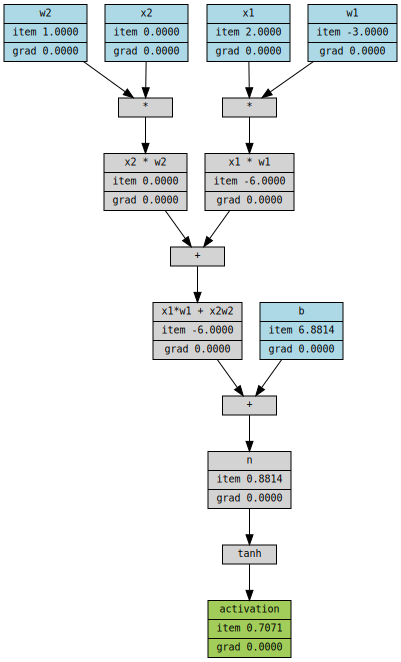

In [51]:
# Inputs
x1 = T([2.0], label='x1')
x2 = T([0.0], label='x2')

# Weights
w1 = T([-3.0], label='w1')
w2 = T([1.0], label='w2')

# Bias of the neuron
b = T([6.88137358], label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2w2'
n = x1w1_x2w2 + b ; n.label = 'n'

act = n.tanh(); act.label= 'activation'

draw_dot(act)

Do you see this? Do you feel it in your bones? **This is what a neuron really looks like.**

...I know what you're thinking. Do we really have to backpropagate manually through this network again?

Fear not, because Python is here to the rescue 🤓

What we'll do instead is to set a gradient function for each operation that gives us what their `T.grad`s ought to be, and then figure out how to call those functions in the right order.

First, we must modify `__init__` and add a `_back` attribute:

In [52]:
def init(self, tensor, _children=(), _op='', label=''):
    if not isinstance(tensor, torch.Tensor):
        tensor = torch.tensor(tensor, dtype=torch.float64)

    self.tensor = tensor
    self.label = label
    self.grad = 0.0
    self._op = _op
    self._prev = set(_children)
    self._back = lambda: None # a function

T.__init__ = init

Then `__add__`:

In [53]:
def add(self, other):
    if not isinstance(other, T):
        other = T(other)

    out = T(self.tensor + other.tensor, (self, other), '+')

    def _back():
        self.grad += 1.0 * out.grad # Note the addition assignment
        other.grad += 1.0 * out.grad
    out._back = _back

    return out

T.__add__ = add

The reason why we used the addition assignment operator `+=` here instead of just setting the gradients can be demonstrated by of a pernicious edge case:

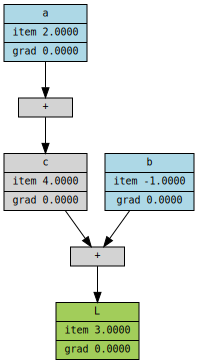

In [54]:
a = T([2.0], label='a')
b = T([-1.0], label='b')

c = a + a ; c.label = 'c' # look here
L = c + b ; L.label = 'L'

draw_dot(L)

Since $c = 2a$, we should get $dc/da = 2$, right? But if we set the gradient here instead of addition-assign it, it will just copy the gradient of $c$ which is wrong.

This observation is corroborated by the formula for the [multivariable chain rule](https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case):

$$
\frac{d}{dx} f(g_1(x), \dots, g_k(x)) = \sum_{i}{\frac{dg_i (x)}{dx} D_i f(g_1(x), \dots, g_k(x))}
$$

where $D_i f$ is the *partial derivative* of $f$ with respect to its $i$ th argument. Or in plain English, to get the change from all the variables, you have to add up all the tiny changes to each variable, which `+=` does, since it accumulates the gradients properly.

In any case, it is instructive to implement `__mul__` yourself:

### Problem 5: Re-implement `__mul__` with the right backpropagation behaviour.

In [55]:
def mul(self, other):
    # YOUR CODE HERE
    if not isinstance(other, T):
        other = T(other)

    out = T(self.tensor * other.tensor, (self, other), '*')

    def _back():
        self.grad += other.tensor
        other.grad += self.tensor
    out._back = _back

    return out

T.__mul__ = mul

For `tanh`:

In [56]:
def tanh(self):
    x = self.item()
    t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
    out = T(t, (self,), 'tanh')

    def _back():
        self.grad += (1 - t**2) * out.grad
    out._back = _back

    return out

T.tanh = tanh

To test this, we must first set `act.grad = 1.0` like we usually do, then call `act._back()`:

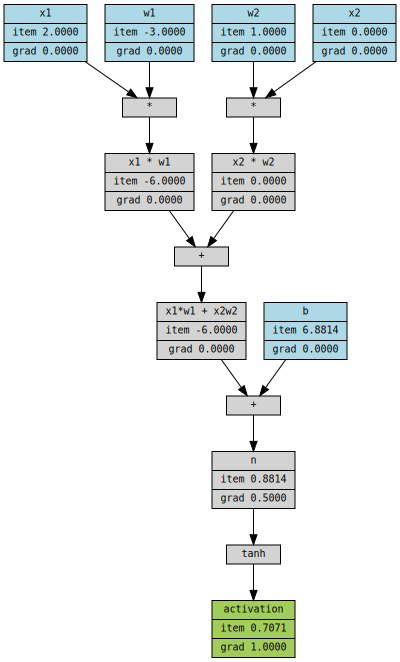

In [57]:
act = n.tanh() ; act.label='activation' # since we changed tanh

act.grad = 1.0
act._back()

draw_dot(act)

See how `n.grad` changed?

Okay, now what we need to do next is to call the `*._backward()` methods in the right order, starting from `act` and going up the graph until we hit all the input nodes. To do this, we must add a `T.backward()` method that constructs what's known as a _topological sort_ of the nodes.

![](https://i.imgur.com/lfD9BPv.png)

This arrangement isn't really unique but we are guaranteed to have at least one for a directed graph if there are no cycles. Since we aren't really studying algorithms, I'll just give you the answer as a helper method:

In [59]:
def back(self):
    # topo is an array because we're doing ordering
    topo = []
    # visited is a set because each node must only be processed once
    visited = set()

    def build_topo(v):
        # if a node has already been processed, don't
        if v not in visited:
            # indicate that the node was processed
            visited.add(v)
            # recursion before append (in the end, the nodes at the bottom of the graph go first)
            for child in v._prev:
                build_topo(child)
            # finally append (the parents go last)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0 # So we don't have to set it manually every time
    for node in reversed(topo):
        node._back()

T.back = back

This sorts the nodes in the right way, then calls `*._backward()` on each of them like we intended.

Reinitialising everything then trying again:

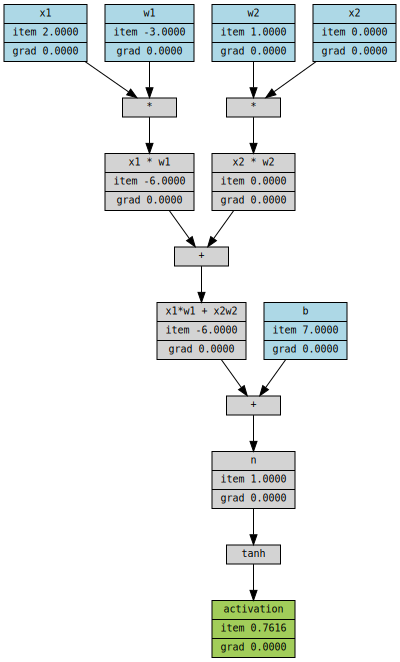

In [60]:
# Inputs
x1 = T([2.0], label='x1')
x2 = T([0.0], label='x2')

# Weights
w1 = T([-3.0], label='w1')
w2 = T([1.0], label='w2')

# Bias of the neuron
b = T([7.0], label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1 * w1'
x2w2 = x2*w2; x2w2.label = 'x2 * w2'

x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = 'x1*w1 + x2w2'
n = x1w1_x2w2 + b ; n.label = 'n'

act = n.tanh(); act.label= 'activation'

draw_dot(act)

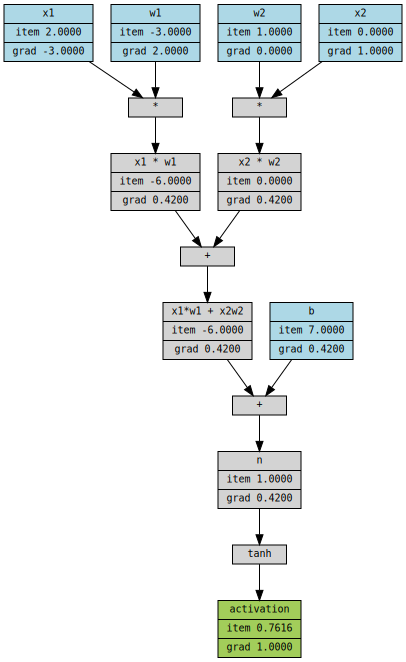

In [61]:
act.back()
draw_dot(act)

### Problem (bonus): Implement the exponential function by defining `T.exp` and make sure it backpropagates properly.

We finally have everything we need to define a `Neuron` class:

In [67]:
import random

class Neuron:
    def __init__(self, nin): # nin := number of inputs
        self.w = [T([random.uniform(-1, 1)], label=f'w{i}') for i in range(nin)]
        self.b = T([random.uniform(-1, 1)], label=f'b')

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

In [68]:
x = [2.0, 3.0]
n = Neuron(2)
n(x) # forward pass

T(item=0.9997774708601651)

And of course, it is very instructive to render this neuron as a computation graph:

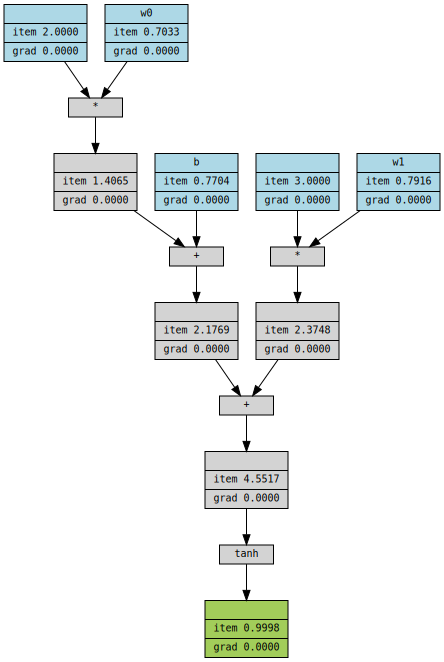

In [69]:
draw_dot(n(x))

As a quick sanity check, try to trace which nodes are the weights, which are inputs, and which is the bias.

### Part III: Network

A **layer** is a collection of neurons that activate, in a very loose sense, 'simultaneously'. Concretely, this is how you make one:

In [70]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # So we can get T instead of [T] if there's just one

And since layers aren't really useful except in the context of a network:

In [72]:
# aka MultiLayer Perceptron, a fancy way of saying (fully connected) neural network
class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [73]:
x = [2.0, 3.0]
nn = MLP(3, [4, 4, 1])
forward = nn(x)

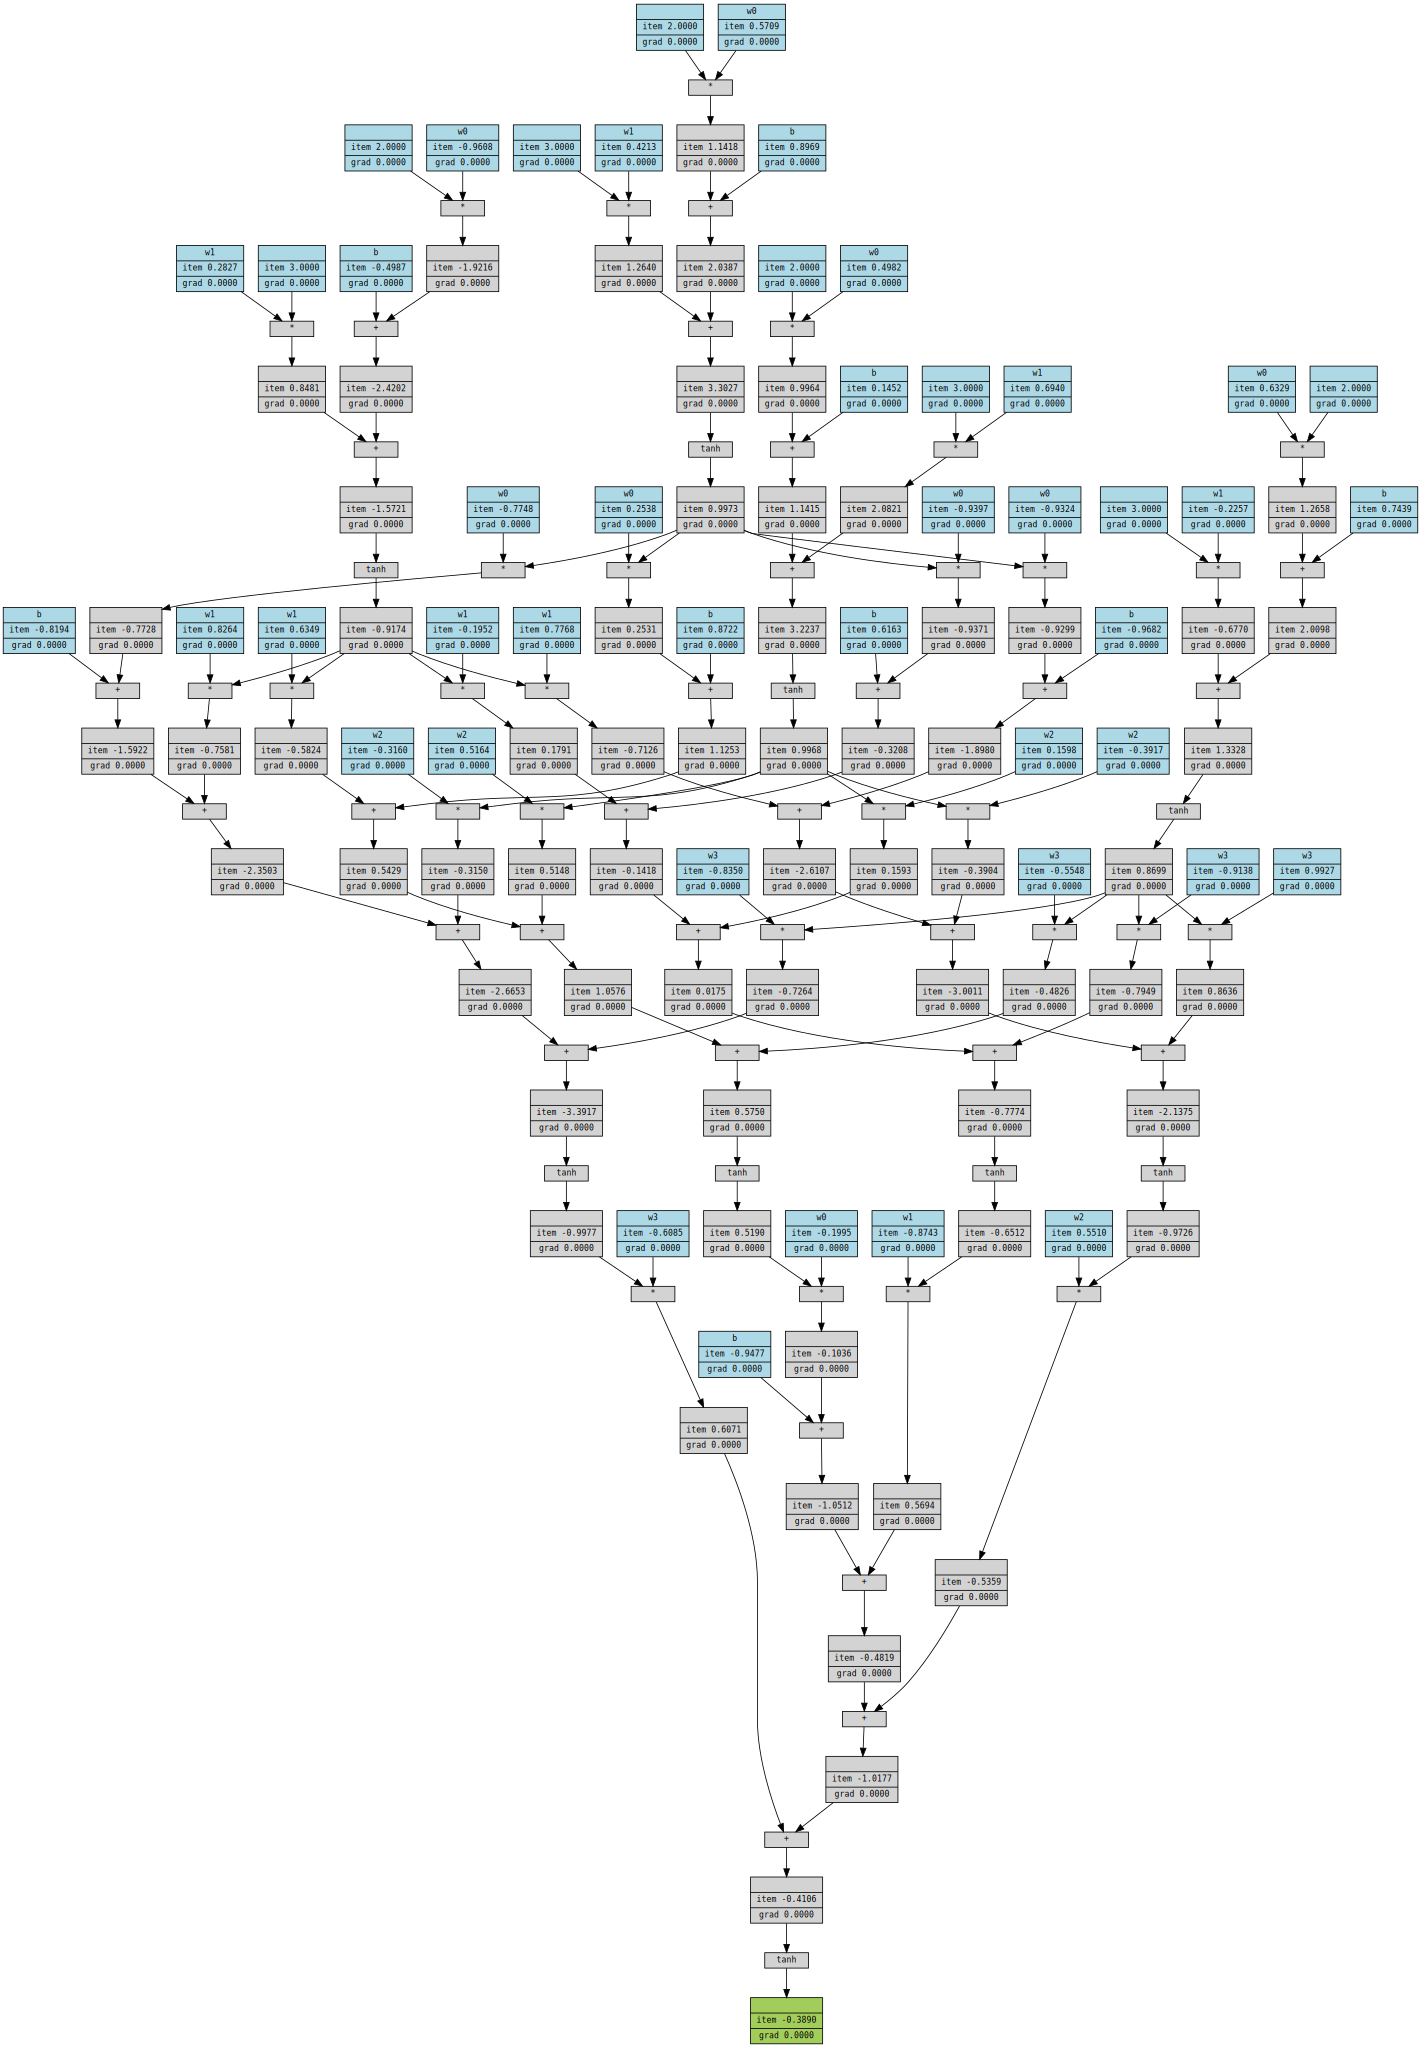

In [74]:
draw_dot(forward)

**Q**: Can you see where the neurons are?

<details>
<summary>Answer</summary>

Look for `tanh`, i.e. the activation function. Each place where it appears is the `end` of a neuron.
</details>


Now, what we want to do here is to feed it some **training data** i.e. a list of inputs and their desired / correct activations. If for example we're trying to classify a bunch of points into positive (denoted $y_i = +1$) and negative ($y_i = -1$) examples, we can write:

In [75]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

ys = [1.0,
     -1.0,
     -1.0,
      1.0]

y_pred = [nn(x) for x in xs]
y_pred

[T(item=-0.33641245356498306),
 T(item=-0.32405389055192946),
 T(item=-0.79315736218044),
 T(item=-0.259803139862026)]

And what we want (and for that matter, what the entire field of machine learning wants) is for `y_pred` to get as close to `ys` as possible.

We can quantify this with a **loss function**: a single number that measures exactly how far we are from `ys`. A simple one is the **mean squared error** loss, which is defined as:

$$
L = \frac{1}{n} \sum{(y'_i - y_i)^2}
$$

where $y'_i$ is the prediction of the network and $n$ is the number of $(y'_i, y_i)$ pairs in consideration.

The idea is, when $L$ is low, that means we're doing good.

In [76]:
preds = zip(y_pred, ys)
len_preds = len(list(map(list, zip(y_pred, ys)))) # zip is consumed when you iterate through it

L = sum((y_prime - y) * (y_prime - y) for y_prime, y in preds) ; L.label = 'loss'
L

T(item=3.8727892169479343)

And if we backprop through it (can you guess how long it'll take?):

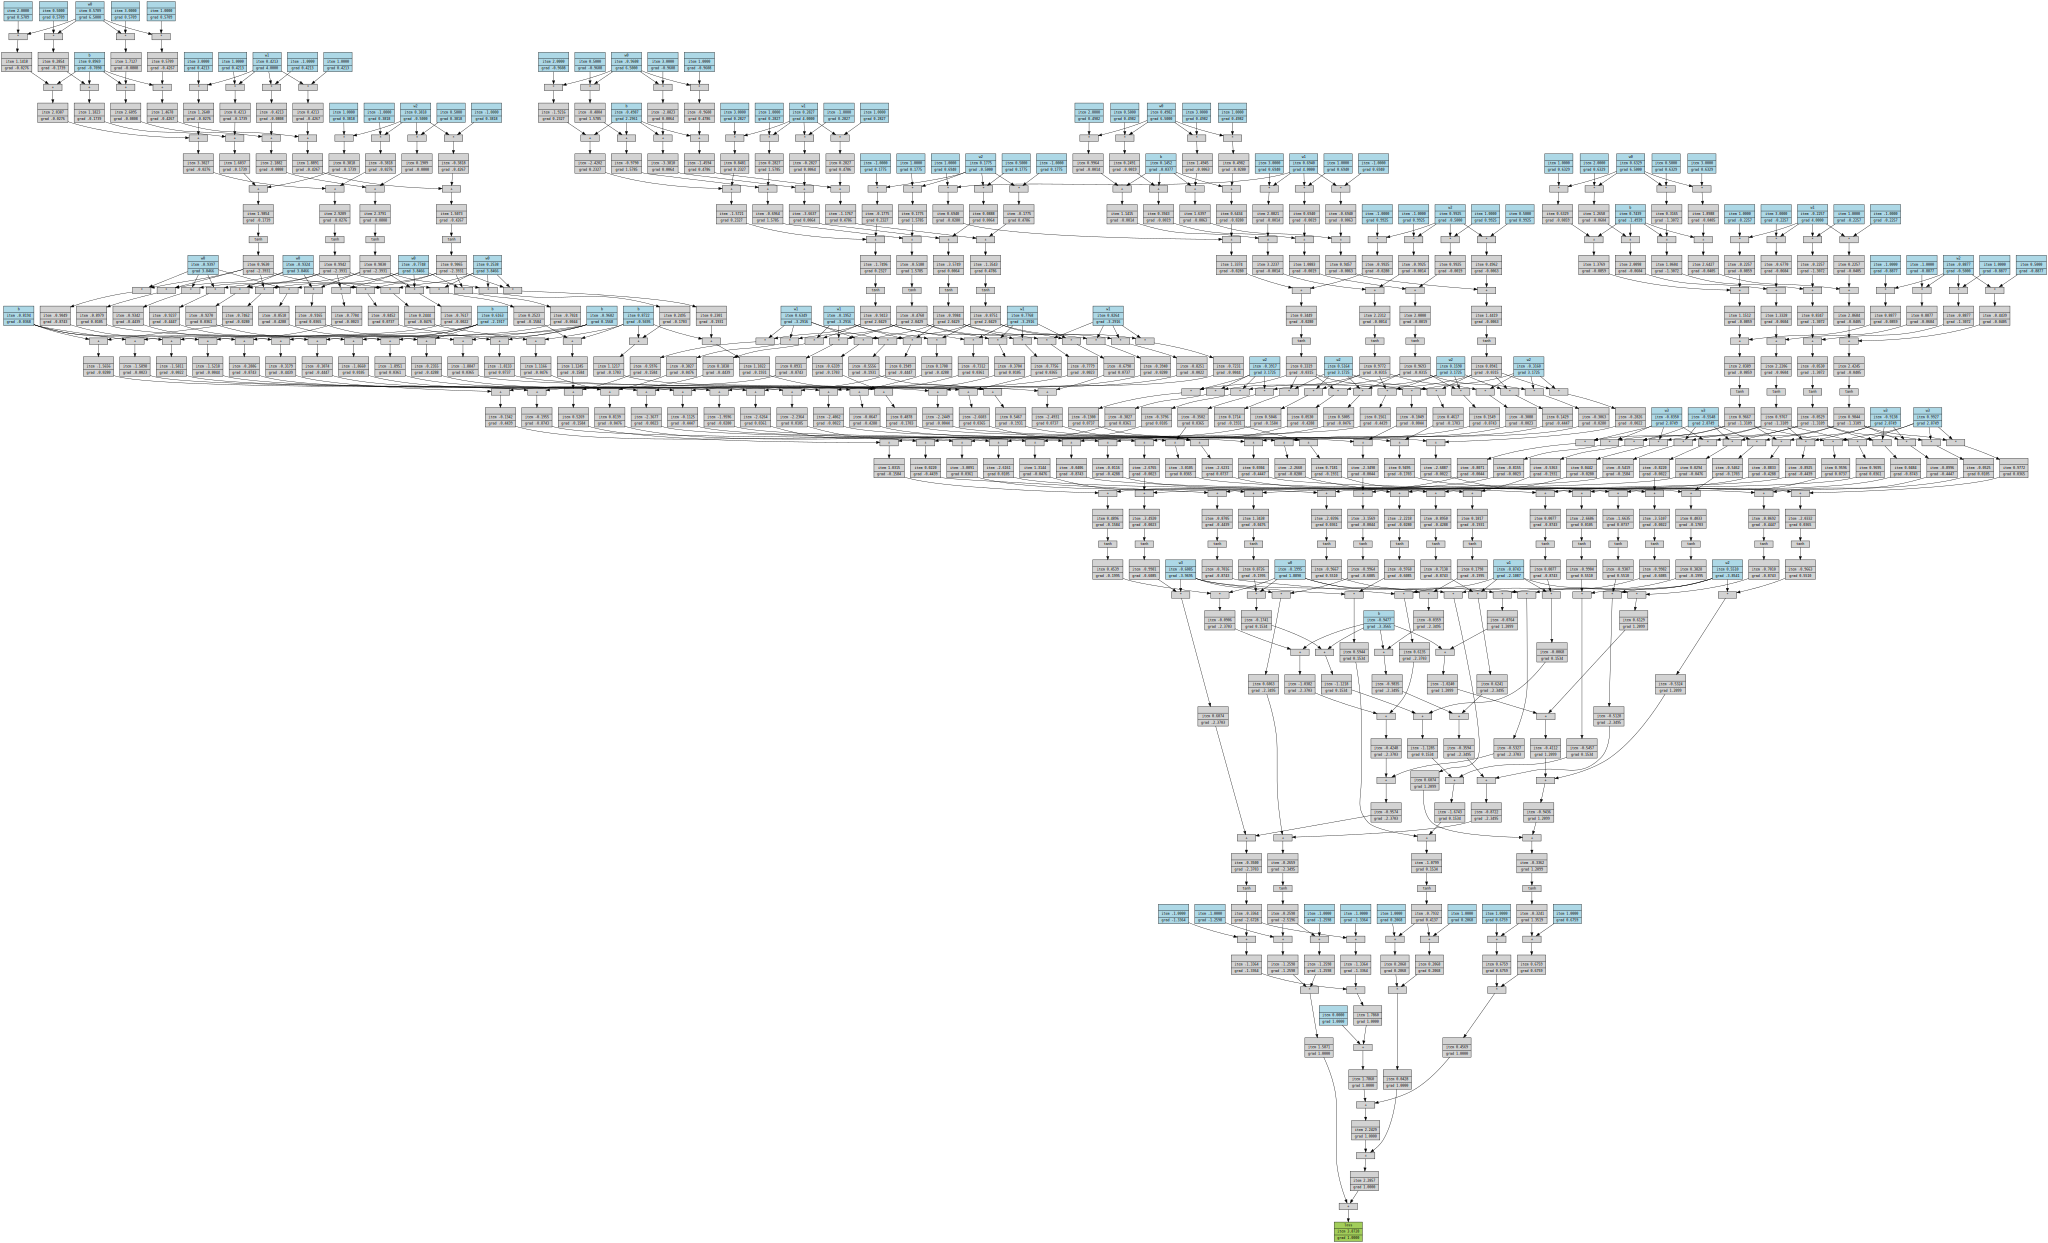

In [77]:
L.back()
draw_dot(L)

Modern computers are _exceptionally_ fast.

You should notice that the computation graph actually contains the training set and even calculates gradients for each of its elements. This isn't really required since we don't really want the training set to change during the optimisation step.

In any case, we want to obtain all the **parameters** of the network (the weights and biases) so we can update them systematically. You'll be given the code for the `Neuron` class; your task is to figure out how to get the parameters for the `Layer` and `MLP` classes as well:

In [117]:
def params(self):
    return self.w + [self.b]

Neuron.params = params
Neuron(2).params()

[T(item=0.20744878302266323),
 T(item=-0.01415438429565019),
 T(item=-0.25968301590411524)]

In [79]:
assert len(Neuron(2).params()) == 3 # w1, w2, b

### Problem 6: Implement `Layer.params` and `MLP.params`.

In [120]:
def params(self):
    # YOUR CODE HERE
    p = []
    for n in self.neurons:
      for w in n.params():
        p.append(w)
    return p

Layer.params = params
Layer(1,3).params()

[T(item=-0.406630920662435),
 T(item=-0.46949638151779793),
 T(item=-0.7563784733091239),
 T(item=0.38493542304514694),
 T(item=0.5620785333143645),
 T(item=0.5982814646986565)]

In [122]:
def params(self):
    # YOUR CODE HERE
    p = []
    for l in self.layers:
      for n in l.neurons:
        for w in n.params():
          p.append(w)
    return p

MLP.params = params
MLP(1, [1, 1, 1]).params()

[T(item=-0.7678764884188258),
 T(item=-0.45042715181206483),
 T(item=-0.7145786393774112),
 T(item=-0.5837666095303122),
 T(item=0.9255783676363243),
 T(item=-0.49725366953287464)]

In [123]:
assert "params" in dir(Layer)
assert "params" in dir(MLP)
assert len(MLP(1, [1, 1, 1]).params()) == 6

Once we have our `*.params` methods, we can perform an optimisation step on the network `nn`. Note that we _decrease_ each parameter since, as we mentioned, we want the loss to go down.

In [124]:
# Setting things up again
nn = MLP(3, [4, 4, 1])

xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

ys = [1.0,
     -1.0,
     -1.0,
      1.0]

In [125]:
nu = 2e-2 # learning rate

# Optimisation step
params = nn.params()
for p in params:
    p.tensor -= nu * p.grad

In [126]:
y_pred = [nn(x) for x in xs]

preds = zip(y_pred, ys)
len_preds = len(list(map(list, zip(y_pred, ys))))

# We haven't implemented division yet, that's why we're multiplying by (1 / len_preds)
L = sum((y_prime - y) * (y_prime - y) for y_prime, y in preds) * (1.0 / len_preds)
L.label = 'loss'
print(f'Loss (initial): {L}')

L.back()

print(f'Loss (t+1): {L}')

Loss (initial): T(item=1.4783023806428313)
Loss (t+1): T(item=1.4783023806428313)


And if we want to keep doing this, we can write a for loop for it.

> [!WARNING]
> You have to set the gradients of every parameter to zero before every backward pass or else your previous training run will bleed into the next. **This is an extremely common mistake that leads to subtle errors.**

In [127]:
iters = 200

losses = []
for i in range(iters):
    # forward pass
    y_pred = [nn(x) for x in xs]
    preds = zip(y_pred, ys)
    len_preds = len(list(map(list, zip(y_pred, ys))))

    L = sum((y_prime - y) * (y_prime - y) for y_prime, y in preds) * (1.0 / len_preds)
    L.label = 'loss'
    losses.append(L)

    # backward pass
    for p in nn.params():
        p.grad = 0.0      # zeroing out the gradients
    L.back()

    # optimisation / update
    for p in nn.params():
        p.tensor -= nu * p.grad


print(f'Loss (final): {losses[-1]}')

fig = px.line(x=range(len(losses)), y=losses, template='ggplot2')
fig.show()

Loss (final): T(item=2.0)


And there you have it! A fully mechanical model of how neural networks work.

Everything else on top of this, from using n-dimensional tensors to more complicated architectures like the transformer, is meant to make this process happen much, much faster.

Lastly, it is instructive to learn how to do this using raw `torch.Tensor` alone:

In [128]:
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([7.0]).double()    ; b.requires_grad  = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(f'activation: {o.data.item()}')
o.backward(retain_graph=True)

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

activation: 0.7615941559557649
---
x2 0.41997434161402614
w2 0.0
x1 -1.2599230248420783
w1 0.8399486832280523


Here, we need to set the attribute `torch.Tensor.requires_grad` to `True` for each parameter so that it retains the gradients of each tensor as well as the `torch.Tensor.grad_fn` (our `T._back` equivalent) that produced it. Also, when calling `Torch.tensor.backward()` we needed to pass in `retain_graph = True` since Pytorch 'forgets' all the intermediate values as soon as it is done backpropagating, for efficiency reasons.

We can then visualise this using the `torchviz` library:

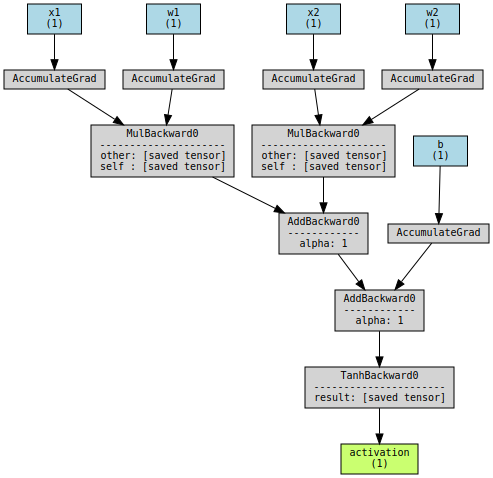

In [129]:
torchviz.make_dot(o, params={
    "x1": x1,
    "x2": x2,
    "w1": w1,
    "w2": w2,
    "b":  b,
    "activation":  o},
    show_attrs=True)

For brevity, this library elides the actual values of the parameters and also introduces an `AccumulateGrad` function before every input node which is doing something similar to our addition assignment operator `+=` earlier. We won't go into the details, but it also makes updating only certain subsets of the parameters possible, which is very useful when you have billions of them.

Then we can redefine `Neuron`, `Layer`, and `MLP` as subclasses of `torch.nn.Module`. For this to work, we need to implement a `forward` method for each of them:

In [130]:
class Neuron(torch.nn.Module):
    def __init__(self, input_size, activation_func=torch.nn.Tanh()):
        # We need to call super to have torch.nn.Module attributes available to us
        super(Neuron, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn(input_size).double())
        self.bias = torch.nn.Parameter(torch.randn(1).double())
        self.activation_func = activation_func

    def forward(self, x):
        # Ensuring x is a row vector for multiplication
        z = torch.matmul(x, self.weight.unsqueeze(-1)).squeeze(-1) + self.bias
        return self.activation_func(z)

In [131]:
class Layer(torch.nn.Module):
    def __init__(self, input_size, output_size, activation_func=torch.nn.Tanh()):
        super(Layer, self).__init__()
        self.neurons = torch.nn.ModuleList([Neuron(input_size, activation_func) for _ in range(output_size)])

    def forward(self, x):
        # Using stack to format outputs as a 1D tensor if there's more than one neuron
        outputs = torch.stack([neuron(x) for neuron in self.neurons], dim=0)
        return outputs

In [132]:
class MLP(torch.nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x).squeeze()  # Ensuring that we pass a 1D tensor to the next layer
        return x

Here, we had to do a bunch of reshaping magic so that our neural network can accept tensors as inputs. This is still the same thing we did last time, except now we're using `torch.matmul` instead so we can take advantage of decades' worth of hardware optimisations for multiplying matrices [2].

[2]: Note we can do these multiplications even faster if we do `torch.set_default_device(torch.device("cuda"))` (`"mps"` if using ARM-based Macs) so that we can use our GPUS, but that will require a bit of device-specific fiddling. We leave it up to you to work that out.

tensor(0.7352, dtype=torch.float64, grad_fn=<SqueezeBackward0>)


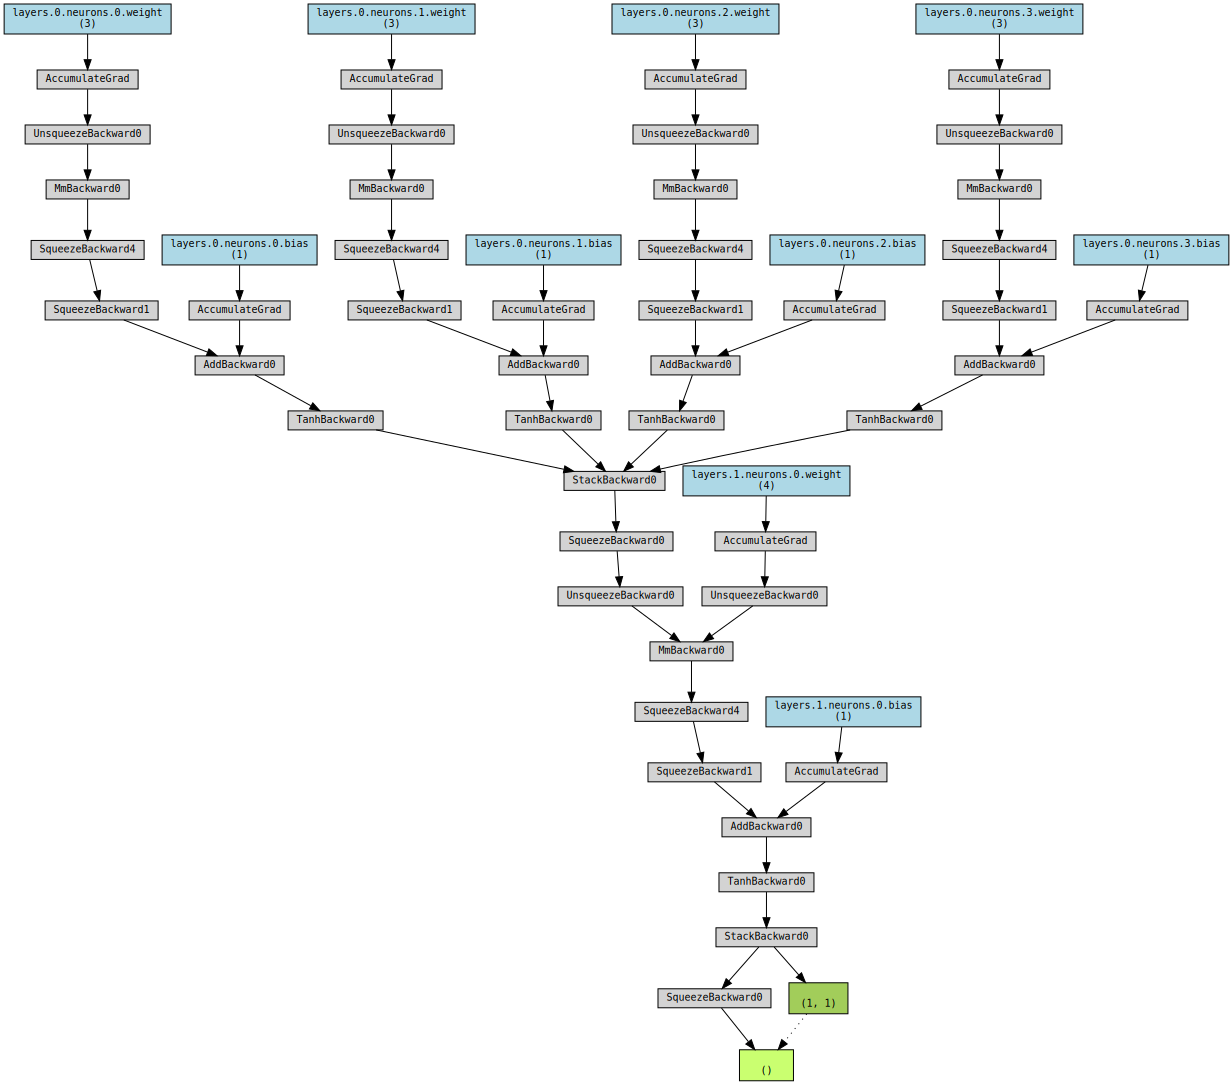

In [133]:
input_tensor = torch.tensor([2.0, 3.0, -1.0], dtype=torch.float32).double()
nn = MLP([3, 4, 1])

output = nn(input_tensor)
output.backward(retain_graph=True) # don't forget retain_graph!
print(output)

torchviz.make_dot(output, params=dict(list(nn.named_parameters())))

Notice how the computation graph keeps track of _everything_, including our reshaping operations.

In [ ]:
# Let's initialise the model again
nn = MLP([3, 4, 1])

xs = torch.tensor([[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]], dtype=torch.float64)
ys = torch.tensor([[1.0], [-1.0], [-1.0], [1.0]], dtype=torch.float64)

# Loss function; same as before (MSE := mean squared error)
criterion = torch.nn.MSELoss()

# We need this so that torch knows how to update our parameters
# Sadly, explaining what this is is out of scope for this challenge
optimizer = torch.optim.SGD(nn.parameters(), lr=0.01)

iters = 200
losses = []

for i in range(iters):
    optimizer.zero_grad()  # Zero the gradients, don't forget!

    # Forward pass
    y_preds = nn(xs)
    loss = criterion(y_preds, ys)
    losses.append(loss.item())

    # Backward pass and optimize
    loss.backward(retain_graph=True)
    optimizer.step()

    if (i+1) % 10 == 0:
        print(f'Iteration {i+1}/{iters}, Loss: {loss.item()}')

fig = px.line(x=range(len(losses)), y=losses, template='ggplot2')
fig.show()

And again, we can visualise the network's computation graph via `torchviz`. We can even see the dimensions of each tensor that was involved in a calculation if we pass in `show_attrs=True`:

In [134]:
# Passing in one of our inputs
torchviz.make_dot(nn(xs[0]), params=dict(list(nn.named_parameters())), show_attrs=True)

TypeError: matmul(): argument 'input' (position 1) must be Tensor, not list

As for what the ridiculously large dimensions mean for the squeezing operations, we leave that for you to figure out. 🙂

## Additional resources

* _Neural Networks: Zero to Hero, building micrograd_, by Andrej Karpathy: [LINK](https://www.youtube.com/watch?v=VMj-3S1tku0)
* _Neural Networks and Deep Learning_, by Michael Nielsen: [LINK](http://neuralnetworksanddeeplearning.com)
* _Intermediate Python Tips_, by @yasoob: [LINK](https://book.pythontips.com/en/latest/classes.html#magic-methods)
* _But what is `torch.nn` really?_ by Jeremy Howard: [LINK](https://pytorch.org/tutorials/beginner/nn_tutorial.html)